In [13]:
import pandas as pd
import random
from time import sleep
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import numpy as np
import nltk
import os
from sklearn import datasets
import pickle
from nltk.tokenize import word_tokenize
from sklearn.decomposition import NMF, TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.neighbors import NearestNeighbors
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, auc, fbeta_score
from sklearn.model_selection import learning_curve, KFold, GridSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from collections import Counter
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.preprocessing import normalize
import re
from unidecode import unidecode

import matplotlib.style as style
%matplotlib inline
plt.style.use('ggplot')

In [14]:
with open('data/cleaned_df.pkl', 'rb') as picklefile:
    df = pickle.load(picklefile)

In [15]:
df.head()

,song_owner,song_title,song_element,verse,artist
0,Childish Gambino,This Is America,[Bridge: Childish Gambino & Young Thug],"We just wanna party, Party just for you, We ju...",Childish Gambino
1,Childish Gambino,This Is America,[Chorus: Childish Gambino],"This is America, Don't catch you slippin' now,...",Childish Gambino
2,Childish Gambino,This Is America,"[Verse 1: Childish Gambino, Blocboy JB, Slim J...","This is America (skrrt, skrrt, woo), Don't cat...",Childish Gambino
3,Childish Gambino,This Is America,[Refrain: Choir & Childish Gambino],"Ooh-ooh-ooh-ooh-ooh, tell somebody, You go tel...",Childish Gambino
4,Childish Gambino,This Is America,"[Chorus: Childish Gambino, Slim Jxmmi & Young ...","This is America (woo, ayy), Don't catch you sl...",Childish Gambino


In [16]:
model_df = df.copy()

In [17]:
model_df['verse_words'] = model_df['verse'].copy()
model_df['verse_words'] = model_df['verse_words'].str.lower()
model_df['verse_words'] = model_df['verse_words'].apply(lambda x: x.replace(',',''))
model_df['verse_words'] = model_df['verse_words'].apply(lambda x: x.split(' '))

In [18]:
model_df.head()

,song_owner,song_title,song_element,verse,artist,verse_words
0,Childish Gambino,This Is America,[Bridge: Childish Gambino & Young Thug],"We just wanna party, Party just for you, We ju...",Childish Gambino,"[we, just, wanna, party, party, just, for, you..."
1,Childish Gambino,This Is America,[Chorus: Childish Gambino],"This is America, Don't catch you slippin' now,...",Childish Gambino,"[this, is, america, don't, catch, you, slippin..."
2,Childish Gambino,This Is America,"[Verse 1: Childish Gambino, Blocboy JB, Slim J...","This is America (skrrt, skrrt, woo), Don't cat...",Childish Gambino,"[this, is, america, (skrrt, skrrt, woo), don't..."
3,Childish Gambino,This Is America,[Refrain: Choir & Childish Gambino],"Ooh-ooh-ooh-ooh-ooh, tell somebody, You go tel...",Childish Gambino,"[ooh-ooh-ooh-ooh-ooh, tell, somebody, you, go,..."
4,Childish Gambino,This Is America,"[Chorus: Childish Gambino, Slim Jxmmi & Young ...","This is America (woo, ayy), Don't catch you sl...",Childish Gambino,"[this, is, america, (woo, ayy), don't, catch, ..."


In [19]:
from nltk.tokenize import word_tokenize
model_df['tokenize_verse'] = model_df['verse'].copy()
model_df['tokenize_verse'] = model_df['tokenize_verse'].str.lower()
model_df['tokenize_verse'] = model_df['tokenize_verse'].apply(lambda x: word_tokenize(x))

In [20]:
model_df['verse'] = model_df['verse'].str.lower()
model_df['verse'] = model_df['verse'].apply(lambda x: x.replace("'",''))
model_df['verse'] = model_df['verse'].apply(lambda x: "".join([c if c.isalnum() else " " for c in x ]))
model_df['verse'] = model_df['verse'].apply(lambda x: x.replace('  ',' '))

In [21]:
stopwords = ["yeah", "uh", "huh", "aw", "oh", "la", "ayy",
            "na", "ha", "ay", "skrrt",
            "em", "bla", "woo", "wu", "ya", "wala", "woop", "wrarrr", "ooh",
            "ba", "duh", "du", "1", "2", "3", "4" ,"5" ,"6", "7", "8", "9", "0"]

for index, row in model_df.iterrows():
    querywords = row['verse'].split()

    resultwords  = [word for word in querywords if word.lower() not in stopwords]
    row['verse'] = ' '.join(resultwords)

model_df.verse[:5]

0    we just wanna party party just for you we just...
1    this is america dont catch you slippin now don...
2    this is america dont catch you slippin now loo...
3    tell somebody you go tell somebody grandma tol...
4    this is america dont catch you slippin now don...
Name: verse, dtype: object

In [22]:
verses = list(model_df.verse.values)

In [23]:
verses[:10]

['we just wanna party party just for you we just want the money money just for you i know you wanna party party just for free girl you got me dancin girl you got me dancin dance and shake the frame we just wanna party party just for you we just want the money money just for you you i know you wanna party party just for free girl you got me dancin girl you got me dancin dance and shake the frame',
 'this is america dont catch you slippin now dont catch you slippin now look what im whippin now this is america dont catch you slippin now dont catch you slippin now look what im whippin now',
 'this is america dont catch you slippin now look how im livin now police be trippin now this is america guns in my area word my area i got the strap i gotta carry ima go into this ugh this is guerilla ima go get the bag or ima get the pad im so cold like im so dope like we gon blow like straight up',
 'tell somebody you go tell somebody grandma told me get your money black man get your black man get yo

In [26]:
all_verses_all_rappers = ','.join(verses)

all_verses_all_rappers[:100]

'we just wanna party party just for you we just want the money money just for you i know you wanna pa'

In [28]:
file = all_verses_all_rappers

In [29]:
# Read in text and change unicode characters to ASCII
import unidecode
import string
import random
import re

all_characters = string.printable
n_characters = len(all_characters)

file_len = len(file)
print(f'file_len = {file_len}')

file_len = 2670560


In [30]:
chunk_len = 400

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

the land where niggas praise yukons and getting paid its gonna take a lot more than coupons to get us saved like it take a lot more than doo rags to get you waves nothing sad as that day my girls father passed away so i promised to mr rainey im gonna marry your daughter and you know i gotta thank you for the way that she was brought up and i know that you were smiling when you see the car i bought 


In [31]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
        
    def forward(self, input, hidden):
        output = self.encoder(input.view(1, -1))
        output, hidden = self.gru(output.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        
        return output, hidden
    
    def init_hidden(self):
        return Variable(torch.randn(self.n_layers, 1, self.hidden_size))

In [32]:
def char2tensor(string):
    tensor = torch.zeros(len(string)).long()
    for char in range(len(string)):
        if string[char] in all_characters:
            tensor[char] = all_characters.index(string[char])
        else:
            tensor[char] = 94 #predict space if character unknown
        
    return Variable(tensor)

# Let's see it in action.
print(char2tensor('Metis0123abczABC'))

tensor([48, 14, 29, 18, 28,  0,  1,  2,  3, 10, 11, 12, 35, 36, 37, 38])


In [33]:
def random_training_set():
    chunk = random_chunk()
    inp = char2tensor(chunk[:-1])
    target = char2tensor(chunk[1:])
    return inp, target

In [34]:
def evaluate(model, prime_str='A', predict_len=100, temperature=0.8):
    
    hidden = model.init_hidden()
    prime_input = char2tensor(prime_str)
    predicted = prime_str
    
    # use priming string to build up hidden state
    
    for p in range(len(prime_str) - 1):
        _, hidden = model(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = model(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char2tensor(predicted_char)
        
    return predicted

In [35]:
# helper function
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds' % (m, s)

In [36]:
# The actual training part
def train(inp, target):
    hidden = model.init_hidden()
    model.zero_grad()
    loss = 0

    for char in range(chunk_len):
        output, hidden = model(inp[char], hidden)
        loss += criterion(output, target[char].unsqueeze(0))

    loss.backward()
    model_optimizer.step()

    return loss.data.item() / chunk_len

In [37]:
# parameters
n_epochs = 1000
print_every = 100
plot_every = 10
hidden_size = 256
n_layers = 2
learning_rate = 0.001

# model declaration
model = RNN(n_characters, hidden_size, n_characters, n_layers)
model_optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate(model, 'A ', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 14s (100 10%) 2.2332]
A bows soh ive wel deny wat alo ald ant eot an ty the the ilr ant bistt te nam any mdenpiths nhat eur  

 39s (200 20%) 1.8642]
A they ling thins got you weed stes eest ing you kswe and thit they nea got the do it mepeld e can sho 

 27s (300 30%) 1.8754]
A i so drack i cauve it bout what it trap i wak up jupp i sear monf the preecaomaint be you pace cold  

 19s (400 40%) 1.7655]
A his but like to bo anothe nigggan the reor fues so say dran he i cluck sop righat not right ired fil 

 10s (500 50%) 1.7297]
A all arany this do,et resper for on bdomen we me to be boy so do off nwo get t lever the gove this hi 

 1s (600 60%) 1.5962]
A billed i come it now a that we my hople penways blow call the his the now fourshin so the that i fig 

 52s (700 70%) 1.6954]
A im she waint she can she nigga told the she needed to summe ant go done was some you got all she gai 

 43s (800 80%) 1.5274]
A cluse them min it jarned worrine scity too and like the femt i girl like my it p

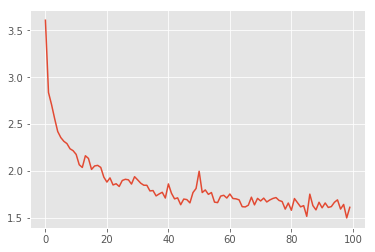

In [38]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [52]:
# Evaluate model from this notebook
print(evaluate(model, 'To be or not to be', predict_len=200, temperature=0.5))

To be or not to been you know the way fuck the back you can the said to the more why in to me of thing you can the rocker to the nigga all be be this bitch the so i needed love a dont got the man a smon the holling the


In [53]:
# Evaluate model from this notebook
print(evaluate(model, 'I miss you girl come back ', predict_len=200, temperature=0.5))

I miss you girl come back down the whole for the feeling on the way was than needer she fame to be she got me rock a love i got the hand so think your said that been not to me all me think the rocks my niggas i m the show the 


In [54]:
# Evaluate model from this notebook
print(evaluate(model, "I'm the realest rapper alive", predict_len=200, temperature=0.5))

I'm the realest rapper alive in the right some the still some i love i way to the was throw your name see your down to now you know you know the for the bad and now a niggas i got the real you know the what you the bast of to th


In [49]:
# Evaluate model from this notebook
print(evaluate(model, "Smoke a lot of weed", predict_len=200, temperature=0.4))

Smoke a lot of weed the rock you know i can the back a real for my money i do it say the love for the show to the down i have down the bad my king comple be some the all for to can shit the place me and we real me for t
